# Learning atomic charges

In [2]:
%pylab inline
import numpy as np
import quippy
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

Populating the interactive namespace from numpy and matplotlib


Load a database of atomic charges

In [3]:
atAll = quippy.AtomsList("data_GDB9.xyz")

Define a SOAP descriptor

In [4]:
Z = 1
desc = quippy.Descriptor(
        "soap atom_sigma=0.3 n_max=10 l_max=10 cutoff=2.5 cutoff_transition_width=0.5 Z={:d} n_species=5 species_Z='1 6 7 8 9'".format(Z))

Evaluate the descriptor for all input configurations. This will take some time to run...

In [5]:
d=[]
c=[]
for at in atAll:
    at.set_cutoff(desc.cutoff())
    at.calc_connect()
    
    descAt = quippy.fzeros((desc.dimensions(),desc.descriptor_sizes(at)[0]))
    desc.calc(at,descriptor_out=descAt)
    
    for dd in descAt:
        d.append(dd)
    for i in quippy.frange(at.n):
        if at.Z[i] == Z:
            c.append(at.charge[i])
d = np.array(d)
c = np.array(c)

Train a GP on a subset of the charge data using the SOAP descriptor

In [7]:
nTeach = 1000
epsTeach = 0.01
zeta = 1
xTeach = d[:nTeach,:]
yTeach = c[:nTeach]

cTeach = np.dot(xTeach,xTeach.T)**zeta + epsTeach**2 * np.eye(nTeach)
alpha = np.linalg.solve(cTeach,yTeach)

In [8]:
xTest = d[nTeach:,:]
yTest = c[nTeach:]
cTest = np.dot(xTest,xTeach.T)**zeta
yTestPredict = np.dot(cTest,alpha)

0.0143970580438


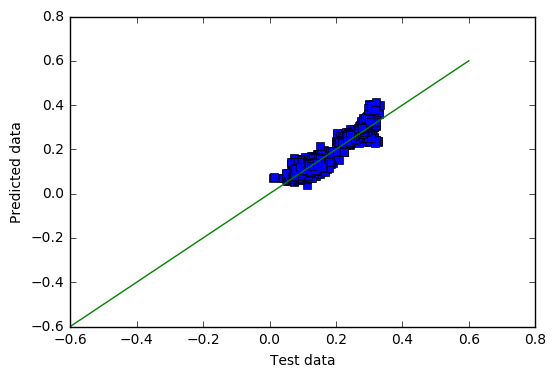

In [9]:
plt.plot(yTest,yTestPredict,"s")
plt.plot([-0.6,0.6],[-0.6,0.6])
plt.xlabel("Test data")
plt.ylabel("Predicted data")
print np.sqrt(np.mean((yTest-yTestPredict)**2))

In [11]:
def likelihood(atIn,atom_sigma=0.4,n_max=10,l_max=10,cutoff=3.0,cutoff_transition_width=0.5,Z=1,zeta=1,eps=0.1):
    desc = quippy.Descriptor("soap atom_sigma={:f} n_max={:d} l_max={:d} cutoff={:f} cutoff_transition_width={:f} Z={:d} n_species=5 species_Z='1 6 7 8 9'".format(atom_sigma,n_max,l_max,cutoff,cutoff_transition_width,Z))

    d=[]
    c=[]
    for at in atIn:
        at.set_cutoff(desc.cutoff())
        at.calc_connect()

        descAt = quippy.fzeros((desc.dimensions(),desc.descriptor_sizes(at)[0]))
        desc.calc(at,descriptor_out=descAt)

        for dd in descAt:
            d.append(dd)
        for i in quippy.frange(at.n):
            if at.Z[i] == Z:
                c.append(at.charge[i])
    d = np.array(d)
    c = np.array(c)
    
    cTeach = np.dot(d,d.T)**zeta + eps**2 * np.eye(len(c))
    alpha = np.linalg.solve(cTeach,c)
    
    l = -0.5 * np.dot(alpha,c) - np.sum(np.log(np.diag(np.linalg.cholesky(cTeach))))
    return l

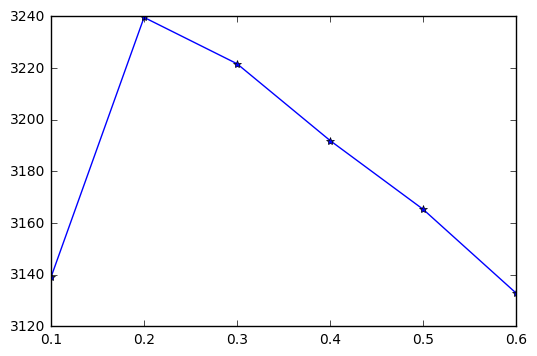

In [12]:
atTeach = atAll[:100]
l=[]
# eps = np.linspace(0.001,0.1,10)
# for e in eps:
#     l.append(likelihood(atTeach,eps=e))
    
# plt.plot(eps,l,"-*")
# plt.show()

# zeta = [1,2,3,4,5,6]
# for z in zeta:
#     l.append(likelihood(atTeach,zeta=z,eps=0.01))
    
# plt.plot(zeta,l,"-*")
# plt.show()

# cutoff = [1.5,2.0,2.5,3.0,3.5]
# for c in cutoff:
#     l.append(likelihood(atTeach,zeta=1,eps=0.01,cutoff=c))
    
# plt.plot(cutoff,l,"-*")
# plt.show()

atom_sigma = [0.1,0.2,0.3,0.4,0.5,0.6]
for a in atom_sigma:
    l.append(likelihood(atTeach,zeta=1,eps=0.01,cutoff=2.5,atom_sigma=a))
    
plt.plot(atom_sigma,l,"-*")
plt.show()